# Radiomics SuStaIn in ASCENT

Using the sustain mamba environment. Try and load the radiomics data and run a test run of sustain

## Clean data

Import features from radiomics, drop extraneous diagnostic columns and create df with only latest cases.

In [22]:
import csv
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

def extract_summit_info(path):
    # Regex patterns
    summit_id_pattern = r'summit-\d+-\w+'
    year_pattern = r'_Y(\d)'
    month_pattern = r'(\d+)M-Lesion'
    lesion_number_pattern = r'Lesion(\d+)'
    
    # Extracting values
    summit_id_match = re.search(summit_id_pattern, path)
    year_match = re.search(year_pattern, path)
    month_match = re.search(month_pattern, path)
    lesion_number_match = re.search(lesion_number_pattern, path)
    
    # Getting matched values or default values
    summit_id = summit_id_match.group(0) if summit_id_match else None
    year = int(year_match.group(1)) if year_match else None
    month = int(month_match.group(1)) if month_match else 0
    lesion_number = int(lesion_number_match.group(1)) if lesion_number_match else None
    
    return {
        "summit_id": summit_id,
        "year": year,
        "month": month,
        "lesion_number": lesion_number
    }



In [60]:
# read in radiomic features CSV
features = pd.read_csv('/home/daryl/Documents/data/radiomics/features_2024-03-25_15-17.csv')

# Read in ascent malignancy data

ascent_malignancy = pd.read_csv('/home/daryl/Documents/data/ascent-clinical/output/ascent_NoduleList.csv')
ascent_malignancy = ascent_malignancy[['scan_name', 'malignancy_diagnosis_ascent']]
ascent_malignancy['malignancy_diagnosis_ascent'] = ascent_malignancy['malignancy_diagnosis_ascent'].map({'Yes': 1, 'No': 0})

# apply the extract_summit_info function to the Mask column and make new columns
features = features.join(features['Mask'].apply(extract_summit_info).apply(pd.Series))

# drop image, mask, and diagnostic columns
df = features.filter(regex='^(?!diagnostics)') 
# mutate Mask column to extract filename
df['Mask'] = df['Mask'].apply(lambda x: Path(x).name)

cols_to_drop = ['Image','Mask']
df = features.drop(columns=cols_to_drop)

# Convert year and month columns to numeric values for proper sorting
df['Year'] = pd.to_numeric(df['year'], errors='coerce')
df['Month'] = pd.to_numeric(df['month'], errors='coerce')

# Create a combined column for sorting
df['Combined'] = df['Year'] * 100 + df['Month']

# Find the indices of the rows with the maximum combined value for each summit_id
idx = df.groupby('summit_id')['Combined'].idxmax()

# Filter the DataFrame based on the identified indices
latest_df = df.loc[idx]

# Drop the temporary 'Combined' column
latest_df = latest_df.drop(['Combined', 'Year', 'Month'], axis=1)
latest_df.reset_index(drop=True, inplace=True)

# Standardise numerical columns in latest_df

original_columns_names = latest_df.filter(regex='^original').columns # numerical columns from radiomics with original filter

# what about if we use all the lesions?

radiomic_features_standardized = StandardScaler().fit_transform(df[original_columns_names].values)
radiomic_features_standardized_latest = StandardScaler().fit_transform(latest_df[original_columns_names].values)


/home/daryl/miniforge3/envs/sustain/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Getting data ready for SuStaIn

Reduce dimensions down to single digit biomarkers using feature correlation, keep indices (summit_id, lesion_number, year and month)

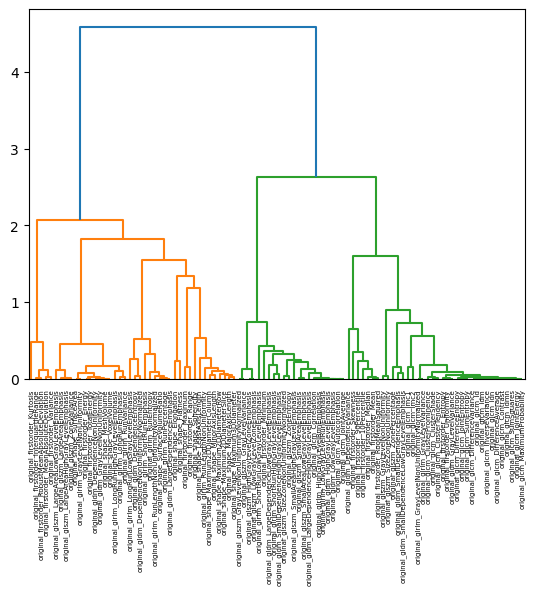

['original_firstorder_InterquartileRange' 'original_shape_MeshVolume'
 'original_shape_SurfaceVolumeRatio' 'original_shape_Elongation'
 'original_firstorder_Minimum' 'original_firstorder_10Percentile'
 'original_firstorder_Entropy']


In [24]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Assuming 'df' is your DataFrame with radiomic features that start with 'original'
radiomic_features = latest_df.filter(like='original')

# Calculate the correlation matrix and then the distance matrix
corr = radiomic_features.corr().abs()
dist = (1 - corr).clip(lower=0)  # Ensure no negative distances

# Convert distance matrix to a format suitable for 'linkage'
dist_squareform = squareform(dist)

# Perform hierarchical clustering
Z = linkage(dist_squareform, 'ward')

# Plot dendrogram (optional, helps in deciding the number of clusters)
dendrogram(Z, labels=radiomic_features.columns)
plt.show()

# Decide on a cutoff and create clusters
max_d = 1.5  # Example cutoff value, adjust based on dendrogram
clusters = fcluster(Z, max_d, criterion='distance')

# Map features to their clusters
cluster_map = pd.Series(clusters, index=radiomic_features.columns)

# Select representative features (one feature per cluster)
# Example: selecting the first feature in each cluster
selected_features = cluster_map.groupby(cluster_map).apply(lambda x: x.index[0]).values

# Selected features based on hierarchical clustering
print(selected_features)


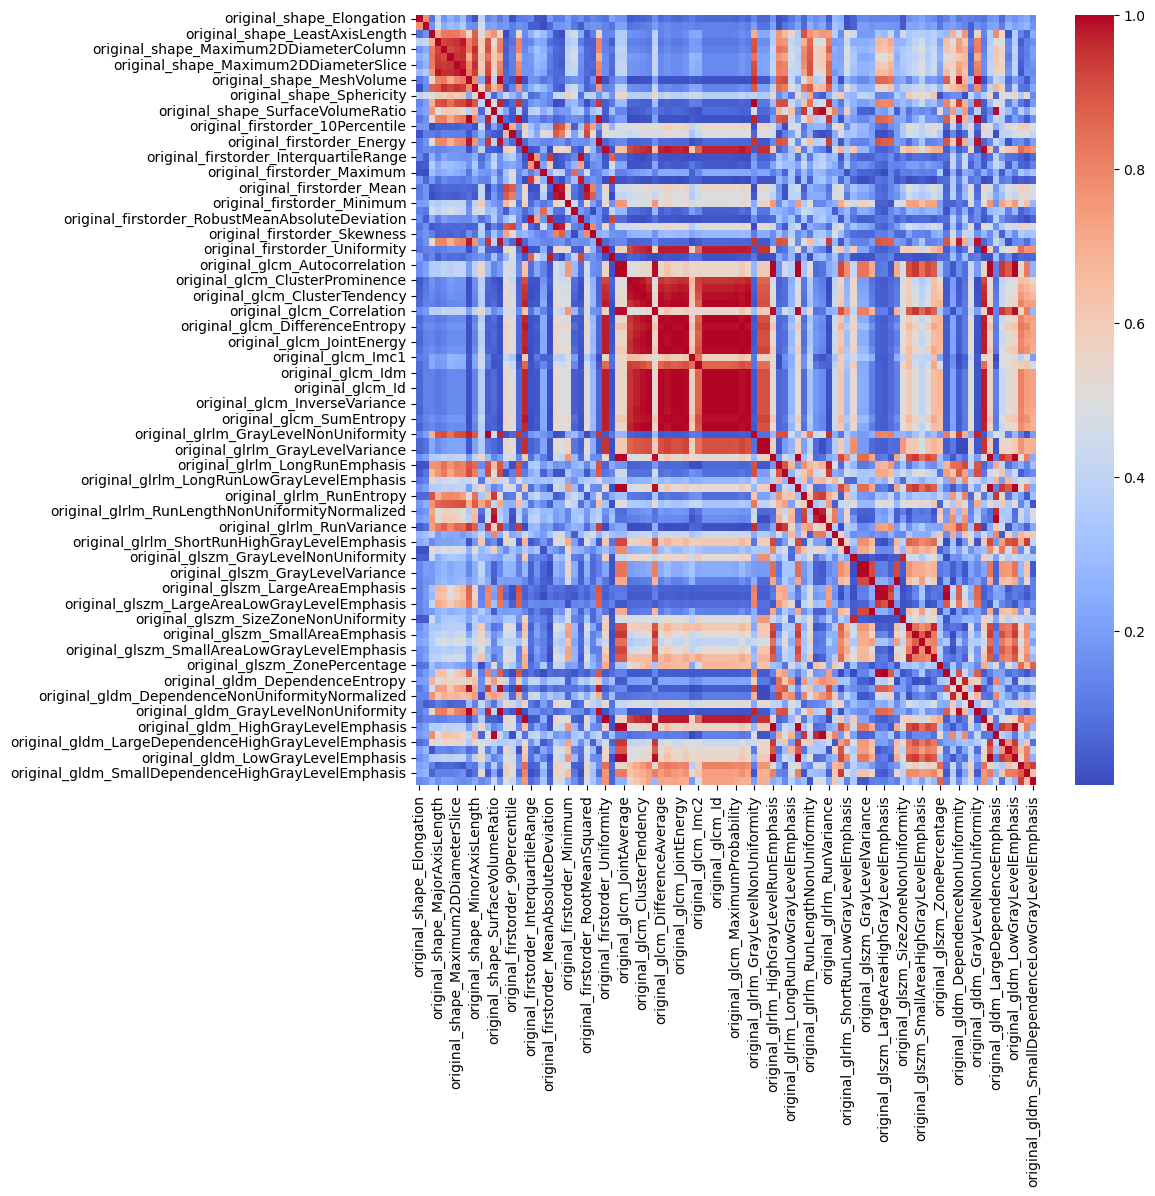

Reduced from 100 to 7 features.
Kept features: ['original_firstorder_InterquartileRange' 'original_shape_MeshVolume'
 'original_shape_SurfaceVolumeRatio' 'original_shape_Elongation'
 'original_firstorder_Minimum' 'original_firstorder_10Percentile'
 'original_firstorder_Entropy']


/home/daryl/miniforge3/envs/sustain/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [25]:
import pandas as pd

# Selecting radiomic features
radiomic_features = latest_df.filter(like='original').columns
X = latest_df[radiomic_features]  # Feature matrix

# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_keep = selected_features # change quick and dirty to HC

# Drop highly correlated features
X_reduced = X[to_keep]

# X_reduced = X.drop(to_drop, axis=1)

# X_reduced now contains features reduced based on correlation
print(f"Reduced from {X.shape[1]} to {X_reduced.shape[1]} features.")
print("Kept features:", to_keep)


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming X_reduced is your DataFrame after removing highly correlated features

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it to z-scores
X_scaled = scaler.fit_transform(X_reduced)
# make all values positive

# Convert the array back to a pandas DataFrame (optional)
# This step retains your feature names, which is useful for interpretability
X_scaled_df = pd.DataFrame(X_scaled, columns=X_reduced.columns)

# X_scaled_df now contains the z-scores of your radiomic features

# Also assuming that both DataFrames are aligned and have the same row order... slightly dodgy

# Directly assign the identifying columns from 'df' to 'X_scaled_df' using the DataFrame's inherent index
X_scaled_df['summit_id'] = latest_df.reset_index()['summit_id']
X_scaled_df['year'] = latest_df.reset_index()['year']
X_scaled_df['month'] = latest_df.reset_index()['month']
X_scaled_df['lesion_number'] = latest_df.reset_index()['lesion_number']
X_scaled_df['scan_name'] = latest_df.reset_index()['Mask']

# 'X_scaled_df' contains the scaled radiomic features along with the original identifying columns


In [27]:
# store our biomarker labels as a variable
biomarkers = X_scaled_df.columns[0:X_reduced.shape[1]]
print(biomarkers)

Index(['original_firstorder_InterquartileRange', 'original_shape_MeshVolume',
       'original_shape_SurfaceVolumeRatio', 'original_shape_Elongation',
       'original_firstorder_Minimum', 'original_firstorder_10Percentile',
       'original_firstorder_Entropy'],
      dtype='object')


## Running SuStaIn

In [46]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn

### Prepare SuStaIn inputs

In [47]:
# Copy original data to avoid modifying it
zdata = pd.DataFrame(X_scaled_df,copy=True)

N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [30]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 3
N_iterations_MCMC = int(1e4)
dataset_name = 'ASCENT_standardscalar'
output_folder = os.path.join(os.getcwd(), 'output', dataset_name)

# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

### Run

In [31]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENT_standardscalar/pickle_files/ASCENT_standardscalar_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem


Overall ML likelihood is -2856.8300388300718


MCMC Iteration: 100%|██████████| 10000/10000 [00:03<00:00, 2531.94it/s]


Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENT_standardscalar/pickle_files/ASCENT_standardscalar_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2775.20078596]
Overall ML likelihood is [-2775.20078596]


MCMC Iteration: 100%|██████████| 10000/10000 [00:08<00:00, 1150.77it/s]


Failed to find pickle file: /home/daryl/Documents/pysustain/pySuStaIn/output/ASCENT_standardscalar/pickle_files/ASCENT_standardscalar_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2752.37614008]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2751.78046674]
Overall ML likelihood is [-2751.78046674]


MCMC Iteration: 100%|██████████| 10000/10000 [00:12<00:00, 818.43it/s]


## Evaluation

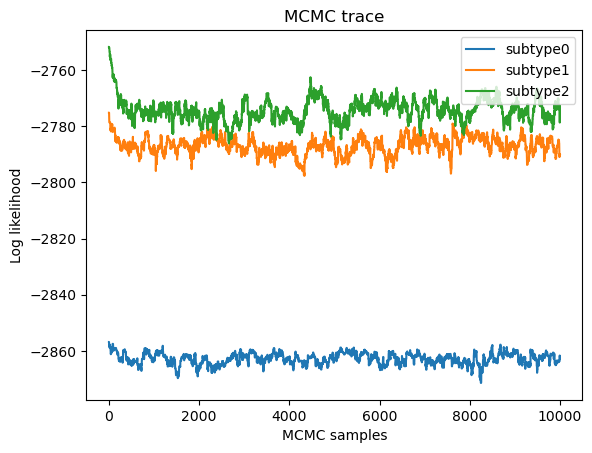

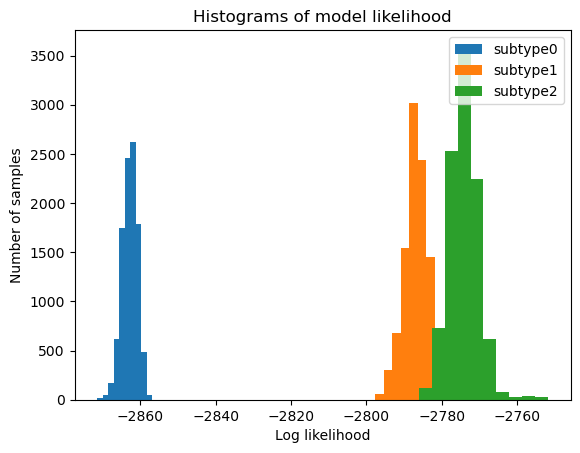

In [40]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')


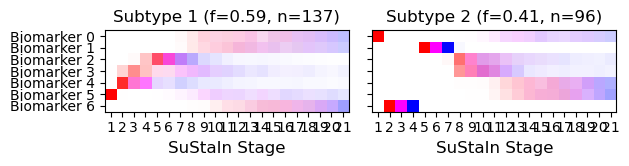

In [56]:
# plot positional variance diagrams to interpret the subtype progressions

s = 1 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))



## Subtype and Staging

In [34]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [35]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,original_firstorder_InterquartileRange,original_shape_MeshVolume,original_shape_SurfaceVolumeRatio,original_shape_Elongation,original_firstorder_Minimum,original_firstorder_10Percentile,original_firstorder_Entropy,summit_id,year,month,lesion_number,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,-0.364063,-0.291840,1.251380,0.360278,2.183272,0.812506,-0.489880,summit-2273-ggq_Y0_BASELINE_A,0,0,3,0.0,0.983695,3.0,0.242325,0.983695
1,-0.434173,-0.289798,1.274967,1.048487,1.918814,1.543379,-0.489880,summit-2273-ggq_Y0_NODULE_FOLLOWUP_3M,0,3,3,0.0,0.994528,3.0,0.237084,0.994528
2,-1.308661,-0.267990,0.847883,0.999412,2.931277,2.247388,-0.489880,summit-2273-ggq_Y1_ALWAYS_SCAN_A,1,0,3,0.0,0.999595,4.0,0.270922,0.999595
3,-0.729083,-0.167648,-0.592360,-0.060509,0.996246,1.030254,-0.489880,summit-2288-yke_Y1_ALWAYS_SCAN_A,1,0,3,0.0,0.896374,0.0,0.312067,0.896374
4,-1.735220,0.219984,-1.232749,-0.645226,-0.663858,1.557563,-0.192489,summit-2297-vyx_Y2,2,0,13,0.0,0.863988,0.0,0.548878,0.863988


In [36]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0

In [37]:
zdata.ml_subtype.value_counts()

0.0    157
1.0     49
2.0     27
Name: ml_subtype, dtype: int64

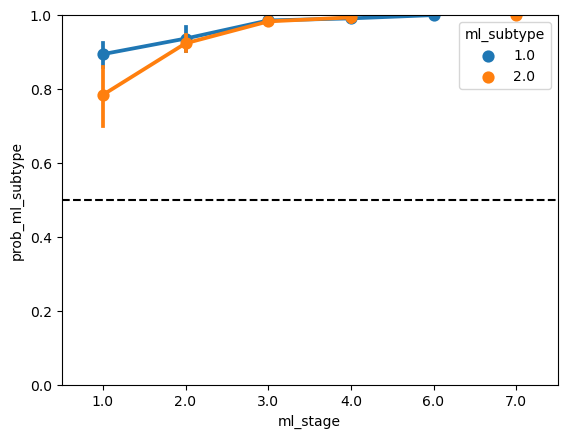

In [43]:
sns.pointplot(x='ml_stage',y='prob_ml_subtype', # input variables
              hue='ml_subtype',                 # "grouping" variable
            data=zdata[zdata.ml_subtype>0]) # only plot for Subtypes 1 and 2 (not 0)
plt.ylim(0,1) 
plt.axhline(0.5,ls='--',color='k') # plot a line representing change (0.5 in the case of 2 subtypes)

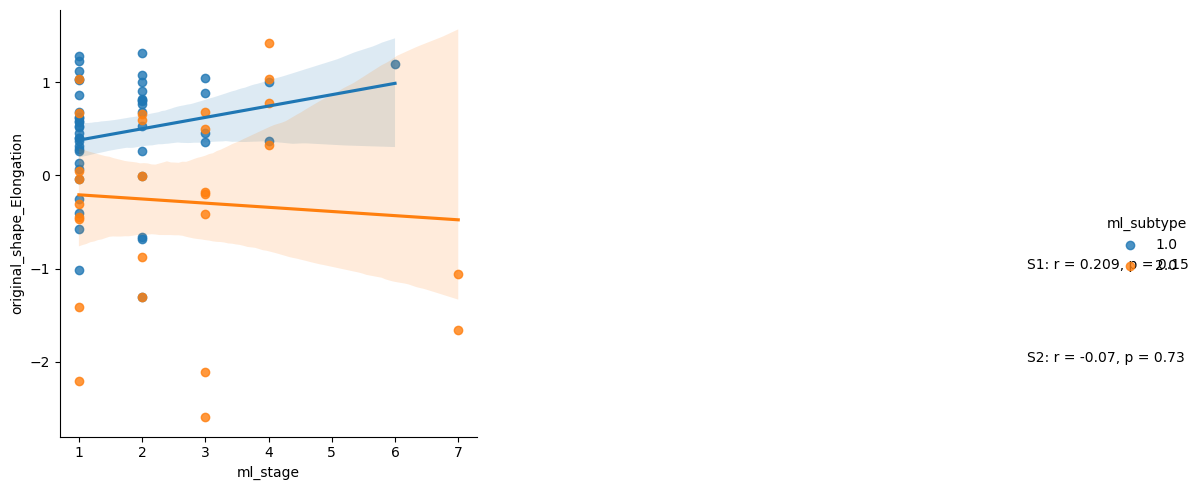

In [44]:
# Plotting relationship between a biomarker and SuStaIn stage across subtypes
from scipy import stats
var = 'original_shape_Elongation'

# plot relationship
sns.lmplot(x='ml_stage',y=var,hue='ml_subtype',
          data = zdata[zdata.ml_subtype>0],
           #lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )

# get stats
for subtype in [1,2]:
    # get r and p value
    r,p = stats.pearsonr(x = zdata.loc[zdata.ml_subtype==subtype,var].values,
                         y = zdata.loc[zdata.ml_subtype==subtype,'ml_stage'].values)
    # add them to plot
    plt.text(16,0-subtype,'S%s: r = %s, p = %s'%(subtype,round(r,3),round(p,2)))